#Breast Cancer Wisconsin Dataset

In [1]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo
!pip install /notebooks/pyade-master

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

#Connect to drive
#from google.colab import drive
#drive.mount('/content/drive')

#Convert and import personalised library
#!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
#!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import utilstfg as utilsTFG


Processing ./pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29472 sha256=c2f324b4f7e90e87ddc4e7809e1af54973cd7f44a0bf5167039793a89d557795
  Stored in directory: /root/.cache/pip/wheels/98/25/f0/ab5adf3c6041d02e08073e288b6daf66206788126fdc60b442
Successfully built pyade-python
  Attempting uninstall: pyade-python
    Found existing installation: pyade-python 1.0
    Uninstalling pyade-python-1.0:
      Successfully uninstalled pyade-python-1.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

utilsTFG.set_seed()

cuda


### Datos y modelos

In [3]:
dataset='bcw'
plot_dataset='BCW'
#Load the dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

#Show the data
print(X.head())


# Show metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# Show variable information
print(breast_cancer_wisconsin_diagnostic.variables)

df=pd.concat([X, y], axis=1)



# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'Diagnosis'


   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

In [4]:
#Show if there is missing data
missing_values = df.isna().sum()
print(missing_values)

#Handle the missing data, filling with the mean
#mis_col = []
#df[mis_col] = df[mis_col].fillna(df.mean())


radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
Diagnosis             0
dtype: int64


In [5]:
# Split indices for training, validation, and test sets
train_val_split = RandomSplitter(valid_pct=0.3, seed=42)(range_of(df))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7, seed=42)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

# Create DataFrames for the splits
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

Diagnosis             1.000000
concave_points3       0.799698
perimeter3            0.786956
radius3               0.779970
concave_points1       0.771185
perimeter1            0.750804
radius1               0.739574
area3                 0.737799
area1                 0.719347
concavity3            0.704608
concavity1            0.701702
compactness3          0.617725
compactness1          0.601868
radius2               0.582443
perimeter2            0.578470
area2                 0.572971
texture3              0.474561
symmetry3             0.440416
texture1              0.411988
smoothness3           0.404806
concave_points2       0.399940
fractal_dimension3    0.331210
symmetry1             0.331141
smoothness1           0.329422
compactness2          0.311723
concavity2            0.271146
smoothness2           0.146286
fractal_dimension2    0.067683
symmetry2             0.056587
fractal_dimension1    0.034183
texture2              0.015190
dtype: float64


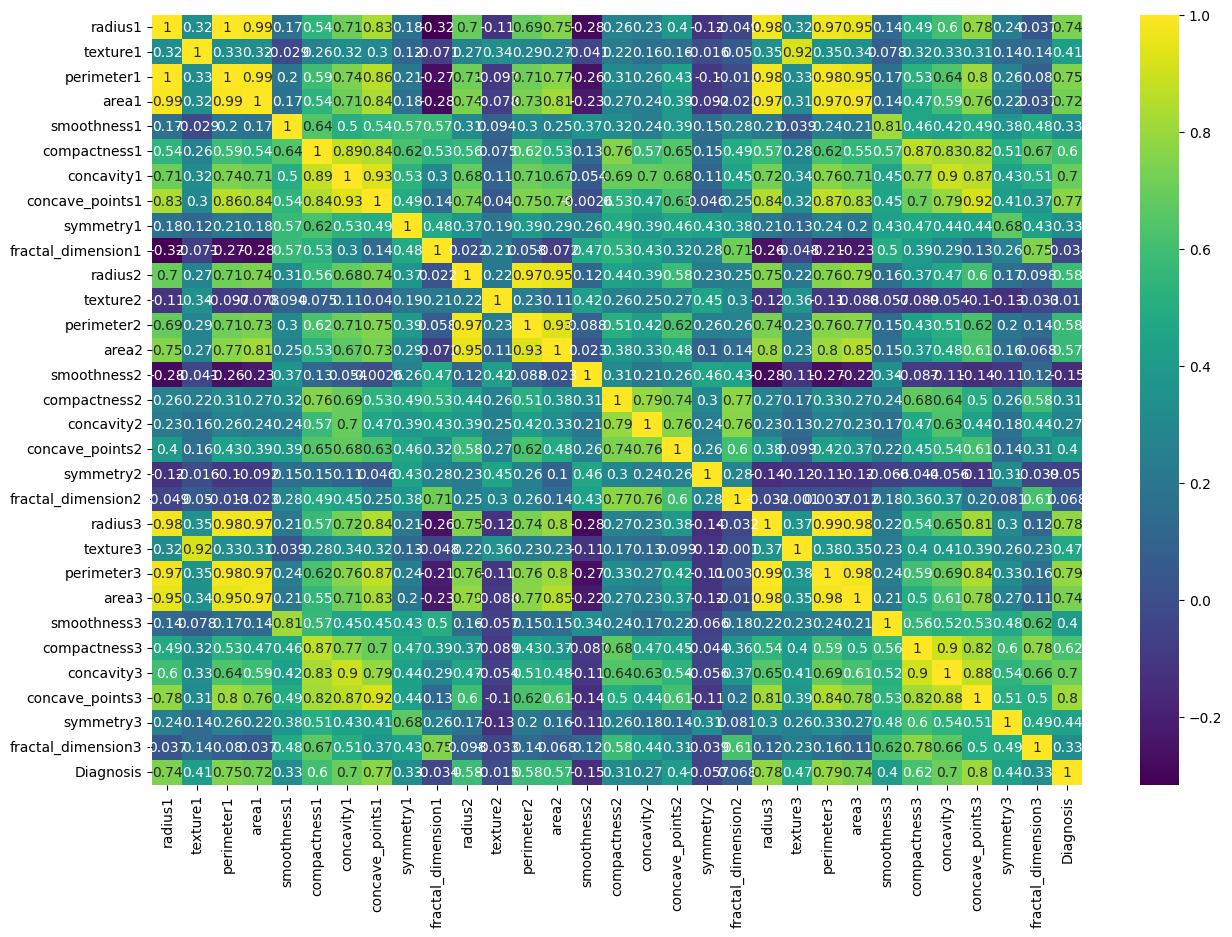

In [6]:
##Preprocessing


# Convert 'Diagnosis' column to numeric values
train_df.loc[:,'Diagnosis'] = train_df['Diagnosis'].map({'M': 1, 'B': 0})
##Preprocessing

#Correlation of all features with the target
corr_mat = train_df.corr()[dep_var]
target_corr = np.abs(train_df.corrwith(train_df[dep_var]))
print(target_corr.sort_values(ascending=False))

#Correlation of features with each other
corr_matrix = train_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()

train_df.loc[:,'Diagnosis'] = train_df['Diagnosis'].map({1: 'M', 0: 'B'})


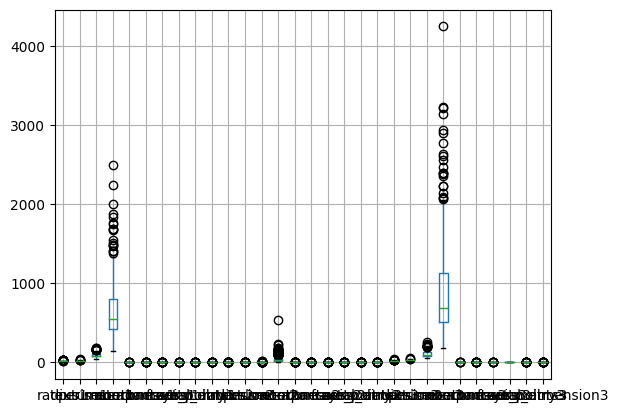

In [7]:
#Boxplot to see the range of feature values
train_df.boxplot()
plt.show()

In [8]:
#Drop features with low correlation with the target
features_to_drop = target_corr[target_corr < 0.1].index
train_df = train_df.drop(columns=features_to_drop)
val_df = val_df.drop(columns=features_to_drop)
test_df = test_df.drop(columns=features_to_drop)
cont_names = [col for col in cont_names if col not in features_to_drop]
print(f"Variables eliminadas: {features_to_drop}")

Variables eliminadas: Index(['fractal_dimension1', 'texture2', 'symmetry2', 'fractal_dimension2'], dtype='object')


In [9]:
# Set the correlation threshold
train_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})
val_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})
test_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})
# Correlation matrix of the training set
corr_matrix = train_df.corr()
threshold = 0.9

# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()

for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrames
train_df.drop(columns=to_drop, inplace=True)
val_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)

# Update the list of continuous names
cont_names = [col for col in cont_names if col not in to_drop]

# Print the dropped features for reference
print(f"Variables eliminadas: {to_drop}")
train_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({1: 'M', 0: 'B'})
val_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({1: 'M', 0: 'B'})
test_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({1: 'M', 0: 'B'})

Variables eliminadas: {'concavity3', 'texture3', 'radius3', 'perimeter3', 'area2', 'concave_points1', 'area3', 'area1', 'perimeter1', 'perimeter2'}


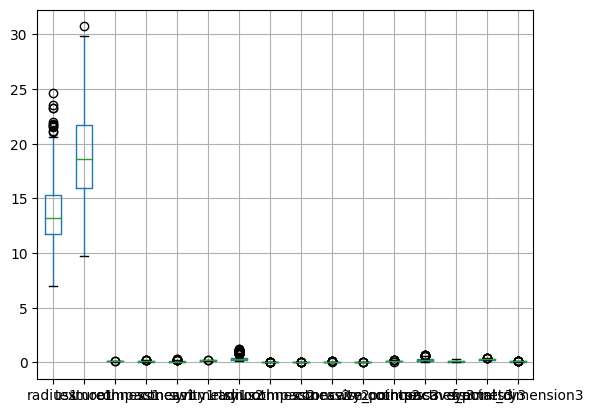

In [10]:
train_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})
val_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})
test_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({'M': 1, 'B': 0})
#Remove outliers
mean = train_df.mean()
std = train_df.std()

z_score_train = ((train_df - mean) / std )
z_score_val = ((val_df - mean) / std )
z_score_test = ((test_df - mean) / std )

outliers_train = (np.abs(z_score_train) > 3 ).any(axis=1)
outliers_val = (np.abs(z_score_val) > 3 ).any(axis=1)
outliers_test = (np.abs(z_score_test) > 3 ).any(axis=1)


train_df_no_outliers = train_df[~outliers_train]
val_df_no_outliers = val_df[~outliers_val]
test_df_no_outliers = test_df[~outliers_test]

train_df_no_outliers.boxplot()
plt.show()
train_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({1: 'M', 0: 'B'})
val_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({1: 'M', 0: 'B'})
test_df.loc[:,'Diagnosis'] = df['Diagnosis'].map({1: 'M', 0: 'B'})

In [11]:
# Normalize the continuous features
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
train_df_no_outliers.loc[:,cont_names] = scaler.fit_transform(train_df_no_outliers.loc[:,cont_names])

# Transform the validation and test data
val_df_no_outliers.loc[:,cont_names] = scaler.transform(val_df_no_outliers.loc[:,cont_names])
test_df_no_outliers.loc[:,cont_names] = scaler.transform(test_df_no_outliers.loc[:,cont_names])


train_df_no_outliers = train_df_no_outliers.reset_index(drop=True)
val_df_no_outliers = val_df_no_outliers.reset_index(drop=True)

# Combine all indices for the splits
splits = (list(train_df_no_outliers.index), list(val_df_no_outliers.index))

# Concatenate the DataFrames back together
df_c = pd.concat([train_df_no_outliers, val_df_no_outliers])

# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)

# Create DataLoaders for training and validation
dls = to.dataloaders(bs=64, shuffle=True)

# Create TabularPandas for the test set
test_to = TabularPandas(
    test_df_no_outliers,  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=64, shuffle=False)
dls.to(device)
test_dl.to(device)

In [12]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM', 'ADAMW']
names_layer=['1 capa', '2 capas', '5 capas', '11 capas']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['BalAcc']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [13]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, n_out=2, layers=layer, metrics=utilsTFG.balanced_accuracy_func, loss_func=CrossEntropyLossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16             
BatchNorm1d                               32         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    1024       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 2              
Linear                                    130        True      
____________________________________________________________________________

Total params: 1,314
Total trainable params: 1,314
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fb0678d2d40>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - Cas

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16             
BatchNorm1d                               32         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    1024       True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 2              
Linear                                    130        True      
____________________________________________________________________________

Total params: 5,538
Total train

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16             
BatchNorm1d                               32         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    1024       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     64 x 256            
Linear                                    32768      T

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16             
BatchNorm1d                               32         True      
____________________________________________________________________________
                     64 x 32             
Linear                                    512        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     64 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     64 x 128            
Linear                                    8192       T

## Gradient Descent

In [14]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
ADAMW = partial(OptimWrapper, opt=torch.optim.AdamW)
optims2 = [NAG, RMSProp, ADAM, ADAMW]
utilsTFG.set_seed()

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, n_out=2,layers=layer, loss_func=CrossEntropyLossFlat(), metrics=utilsTFG.balanced_accuracy_func, opt_func=opt2, cbs=[SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [ ]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")

### Nesterov

Better model found at epoch 0 with valid_loss value: 0.7128502726554871.
Better model found at epoch 1 with valid_loss value: 0.5955356955528259.
Better model found at epoch 2 with valid_loss value: 0.40237098932266235.
Better model found at epoch 3 with valid_loss value: 0.26376765966415405.
Better model found at epoch 4 with valid_loss value: 0.18935711681842804.
Better model found at epoch 5 with valid_loss value: 0.16255474090576172.
Better model found at epoch 6 with valid_loss value: 0.14214299619197845.
Better model found at epoch 7 with valid_loss value: 0.12840616703033447.
Better model found at epoch 8 with valid_loss value: 0.11817731708288193.
Better model found at epoch 9 with valid_loss value: 0.11634936928749084.
Better model found at epoch 10 with valid_loss value: 0.11364894360303879.
Better model found at epoch 11 with valid_loss value: 0.11085058003664017.
Better model found at epoch 12 with valid_loss value: 0.10804808139801025.
Better model found at epoch 13 with v

Better model found at epoch 0 with valid_loss value: 0.8905256986618042.
Better model found at epoch 1 with valid_loss value: 0.6748789548873901.
Better model found at epoch 2 with valid_loss value: 0.3286374807357788.
Better model found at epoch 3 with valid_loss value: 0.20494522154331207.
Better model found at epoch 4 with valid_loss value: 0.16405488550662994.
Better model found at epoch 5 with valid_loss value: 0.13481292128562927.
Better model found at epoch 6 with valid_loss value: 0.12744231522083282.
Better model found at epoch 7 with valid_loss value: 0.10540106147527695.
Better model found at epoch 8 with valid_loss value: 0.10215283185243607.
Better model found at epoch 9 with valid_loss value: 0.09901876002550125.
Better model found at epoch 14 with valid_loss value: 0.09849341213703156.
Better model found at epoch 15 with valid_loss value: 0.09662973880767822.
Better model found at epoch 16 with valid_loss value: 0.0937814861536026.
Better model found at epoch 18 with val

Better model found at epoch 0 with valid_loss value: 0.6245629191398621.
Better model found at epoch 1 with valid_loss value: 0.5260452032089233.
Better model found at epoch 2 with valid_loss value: 0.3728181719779968.
Better model found at epoch 3 with valid_loss value: 0.2605726718902588.
Better model found at epoch 4 with valid_loss value: 0.18577764928340912.
Better model found at epoch 5 with valid_loss value: 0.1533171832561493.
Better model found at epoch 6 with valid_loss value: 0.12771180272102356.
Better model found at epoch 7 with valid_loss value: 0.11555298417806625.
Better model found at epoch 8 with valid_loss value: 0.09911178052425385.
Better model found at epoch 10 with valid_loss value: 0.093699611723423.
Better model found at epoch 11 with valid_loss value: 0.07786448299884796.
Better model found at epoch 12 with valid_loss value: 0.07349100708961487.
Better model found at epoch 13 with valid_loss value: 0.06830183416604996.
Better model found at epoch 14 with valid

Better model found at epoch 0 with valid_loss value: 0.6213268637657166.
Better model found at epoch 3 with valid_loss value: 0.5270785093307495.
Better model found at epoch 4 with valid_loss value: 0.38293758034706116.
Better model found at epoch 5 with valid_loss value: 0.19120505452156067.
Better model found at epoch 6 with valid_loss value: 0.1385296732187271.
Better model found at epoch 7 with valid_loss value: 0.11761544644832611.
Better model found at epoch 8 with valid_loss value: 0.06685401499271393.
Better model found at epoch 9 with valid_loss value: 0.05927937477827072.
Better model found at epoch 10 with valid_loss value: 0.0518430694937706.
Better model found at epoch 11 with valid_loss value: 0.04623788595199585.
Better model found at epoch 12 with valid_loss value: 0.03634529933333397.
Better model found at epoch 13 with valid_loss value: 0.028386307880282402.
Better model found at epoch 14 with valid_loss value: 0.022621171548962593.


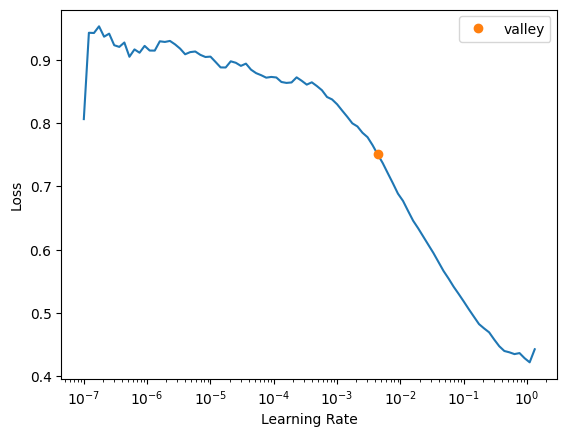

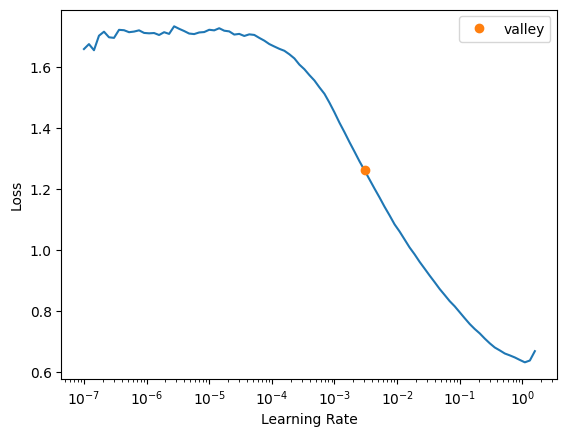

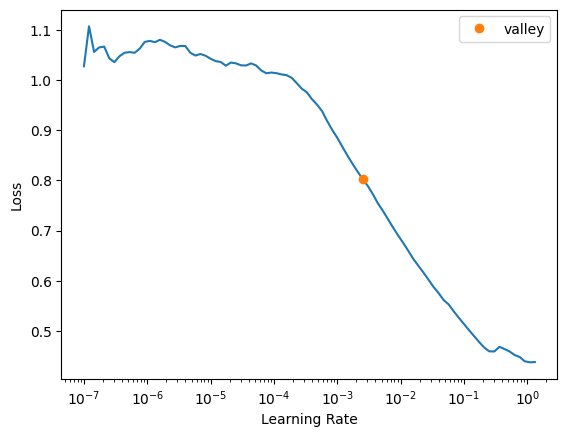

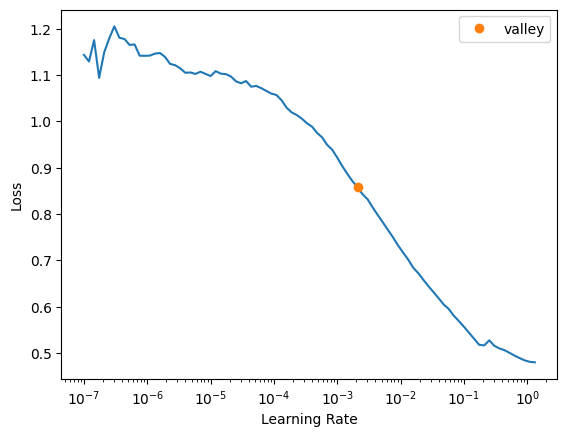

In [18]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



<Figure size 1200x600 with 0 Axes>

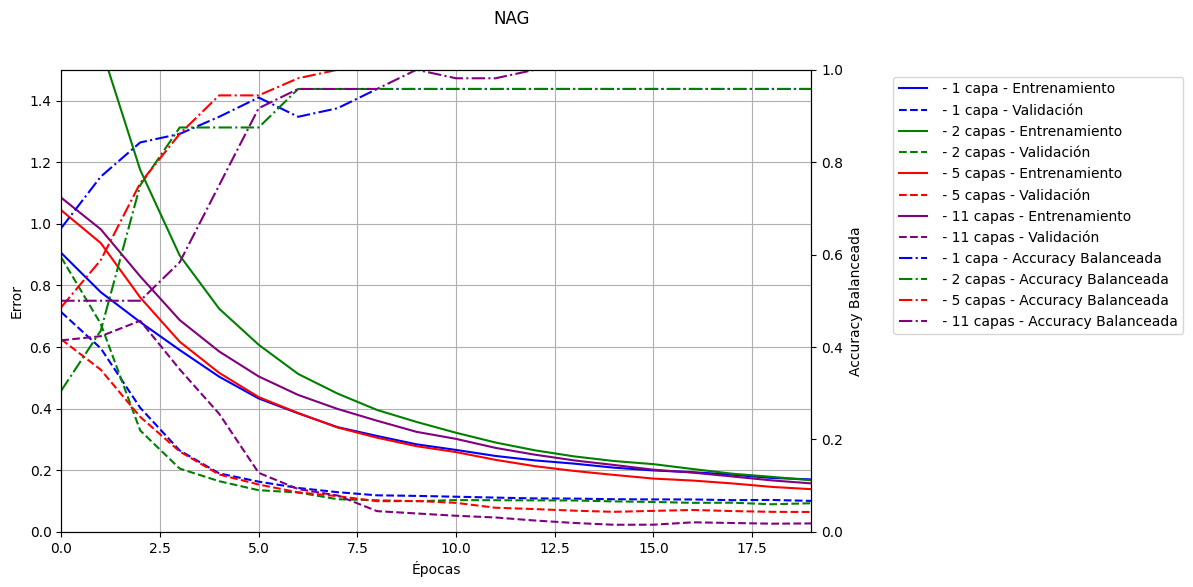

In [21]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title='NAG', names=names_layer, lim=1.5, metric=metric)

### RMSProp

Better model found at epoch 0 with valid_loss value: 0.4897359311580658.
Better model found at epoch 1 with valid_loss value: 0.17351442575454712.
Better model found at epoch 2 with valid_loss value: 0.08500553667545319.
Better model found at epoch 3 with valid_loss value: 0.06173892691731453.
Better model found at epoch 5 with valid_loss value: 0.050542376935482025.
Better model found at epoch 6 with valid_loss value: 0.04646974056959152.
Better model found at epoch 7 with valid_loss value: 0.04465426504611969.
Better model found at epoch 10 with valid_loss value: 0.03397113457322121.
Better model found at epoch 11 with valid_loss value: 0.030671263113617897.


Better model found at epoch 0 with valid_loss value: 0.4979115426540375.
Better model found at epoch 1 with valid_loss value: 0.18562845885753632.
Better model found at epoch 2 with valid_loss value: 0.13989907503128052.
Better model found at epoch 3 with valid_loss value: 0.04944487288594246.
Better model found at epoch 4 with valid_loss value: 0.027296600863337517.
Better model found at epoch 5 with valid_loss value: 0.027135606855154037.
Better model found at epoch 6 with valid_loss value: 0.021139293909072876.
Better model found at epoch 10 with valid_loss value: 0.01856883615255356.
Better model found at epoch 11 with valid_loss value: 0.018448567017912865.


Better model found at epoch 0 with valid_loss value: 0.5595560669898987.
Better model found at epoch 1 with valid_loss value: 0.3222590386867523.
Better model found at epoch 2 with valid_loss value: 0.17353755235671997.
Better model found at epoch 3 with valid_loss value: 0.04772873595356941.
Better model found at epoch 4 with valid_loss value: 0.032412461936473846.
Better model found at epoch 5 with valid_loss value: 0.02670641429722309.
Better model found at epoch 6 with valid_loss value: 0.02420775033533573.
Better model found at epoch 7 with valid_loss value: 0.01622210629284382.
Better model found at epoch 8 with valid_loss value: 0.014442198909819126.
Better model found at epoch 9 with valid_loss value: 0.01239645853638649.
Better model found at epoch 15 with valid_loss value: 0.011669066734611988.
Better model found at epoch 16 with valid_loss value: 0.009251213632524014.
Better model found at epoch 17 with valid_loss value: 0.00887227151542902.
Better model found at epoch 18 wi

Better model found at epoch 0 with valid_loss value: 0.6067900061607361.
Better model found at epoch 1 with valid_loss value: 0.494148850440979.
Better model found at epoch 2 with valid_loss value: 0.2285291999578476.
Better model found at epoch 3 with valid_loss value: 0.16783124208450317.
Better model found at epoch 6 with valid_loss value: 0.035548944026231766.
Better model found at epoch 8 with valid_loss value: 0.03355064243078232.
Better model found at epoch 14 with valid_loss value: 0.0275052972137928.
Better model found at epoch 15 with valid_loss value: 0.018802443519234657.
Better model found at epoch 16 with valid_loss value: 0.016327552497386932.


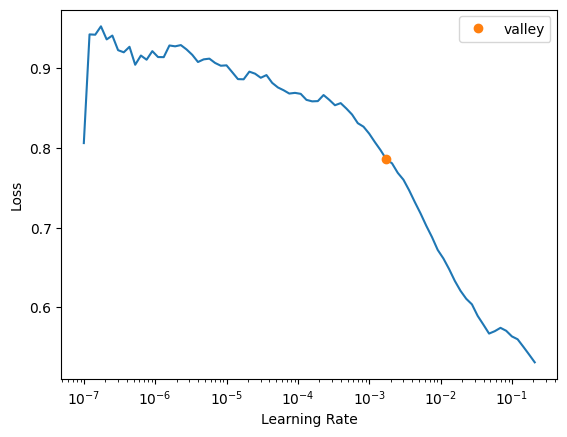

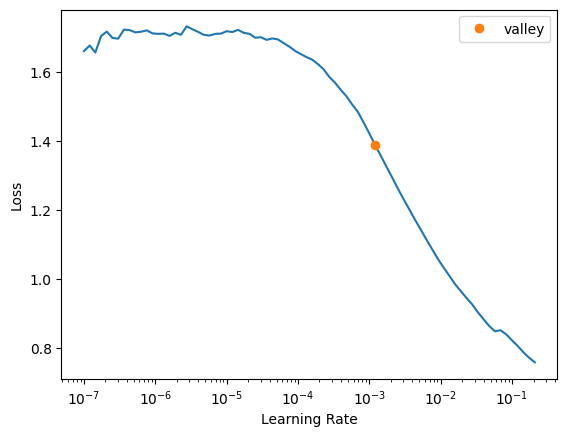

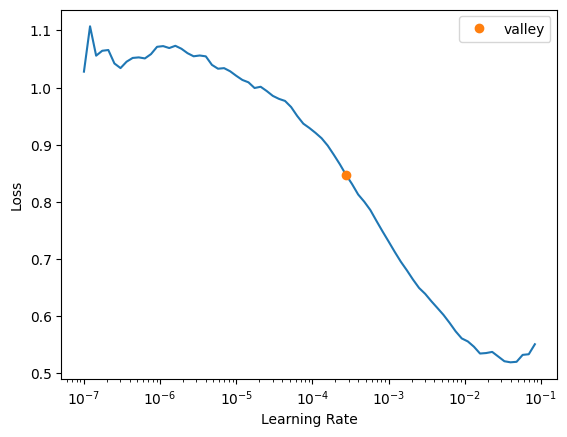

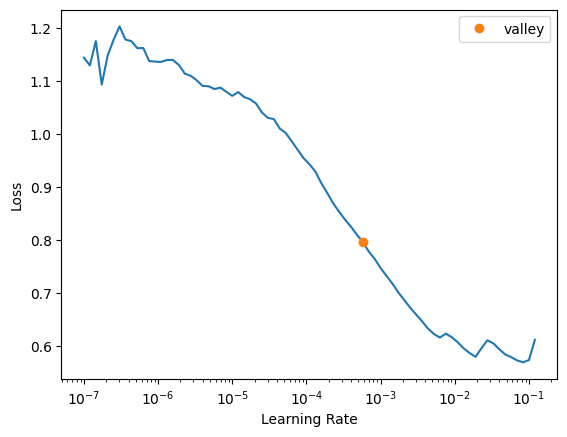

In [20]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

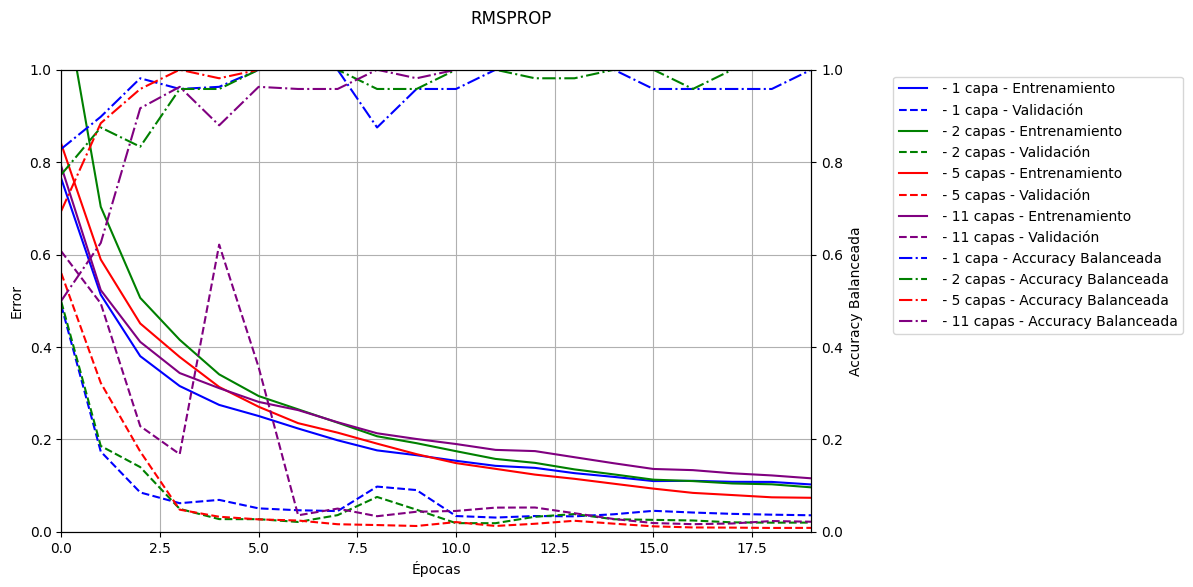

In [20]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title='RMSPROP', names=names_layer, metric=metric)

### Adam

Better model found at epoch 0 with valid_loss value: 0.7123433947563171.
Better model found at epoch 1 with valid_loss value: 0.6381369829177856.
Better model found at epoch 2 with valid_loss value: 0.5225598812103271.
Better model found at epoch 3 with valid_loss value: 0.4110043942928314.
Better model found at epoch 4 with valid_loss value: 0.2859632968902588.
Better model found at epoch 5 with valid_loss value: 0.21417617797851562.
Better model found at epoch 6 with valid_loss value: 0.17117905616760254.
Better model found at epoch 7 with valid_loss value: 0.14890988171100616.
Better model found at epoch 8 with valid_loss value: 0.13022488355636597.
Better model found at epoch 9 with valid_loss value: 0.1243462935090065.
Better model found at epoch 10 with valid_loss value: 0.1161239817738533.
Better model found at epoch 11 with valid_loss value: 0.11204792559146881.
Better model found at epoch 12 with valid_loss value: 0.10760661959648132.
Better model found at epoch 13 with valid_

Better model found at epoch 0 with valid_loss value: 0.8550288081169128.
Better model found at epoch 1 with valid_loss value: 0.6367188692092896.
Better model found at epoch 2 with valid_loss value: 0.31805306673049927.
Better model found at epoch 3 with valid_loss value: 0.18296656012535095.
Better model found at epoch 4 with valid_loss value: 0.1274554431438446.
Better model found at epoch 5 with valid_loss value: 0.09583766013383865.
Better model found at epoch 7 with valid_loss value: 0.0771447941660881.
Better model found at epoch 8 with valid_loss value: 0.06677203625440598.
Better model found at epoch 9 with valid_loss value: 0.05394204333424568.
Better model found at epoch 10 with valid_loss value: 0.05328192561864853.
Better model found at epoch 11 with valid_loss value: 0.05317877605557442.
Better model found at epoch 13 with valid_loss value: 0.05164752155542374.
Better model found at epoch 14 with valid_loss value: 0.04547058790922165.
Better model found at epoch 15 with va

Better model found at epoch 0 with valid_loss value: 0.6082367897033691.
Better model found at epoch 1 with valid_loss value: 0.46743080019950867.
Better model found at epoch 2 with valid_loss value: 0.30676695704460144.
Better model found at epoch 3 with valid_loss value: 0.1982855498790741.
Better model found at epoch 4 with valid_loss value: 0.11318918317556381.
Better model found at epoch 5 with valid_loss value: 0.06952884048223495.
Better model found at epoch 6 with valid_loss value: 0.06874396651983261.
Better model found at epoch 7 with valid_loss value: 0.06270205974578857.
Better model found at epoch 8 with valid_loss value: 0.035739071667194366.
Better model found at epoch 9 with valid_loss value: 0.033801645040512085.
Better model found at epoch 10 with valid_loss value: 0.02889358066022396.
Better model found at epoch 11 with valid_loss value: 0.022130899131298065.
Better model found at epoch 12 with valid_loss value: 0.016002126038074493.
Better model found at epoch 13 wi

Better model found at epoch 0 with valid_loss value: 0.6198810338973999.
Better model found at epoch 1 with valid_loss value: 0.6097000241279602.
Better model found at epoch 2 with valid_loss value: 0.5670603513717651.
Better model found at epoch 3 with valid_loss value: 0.4109107255935669.
Better model found at epoch 4 with valid_loss value: 0.24255229532718658.
Better model found at epoch 5 with valid_loss value: 0.08802010118961334.
Better model found at epoch 6 with valid_loss value: 0.03417845442891121.
Better model found at epoch 10 with valid_loss value: 0.029550857841968536.
Better model found at epoch 12 with valid_loss value: 0.013039245270192623.
Better model found at epoch 13 with valid_loss value: 0.00945900846272707.
Better model found at epoch 14 with valid_loss value: 0.009046985767781734.


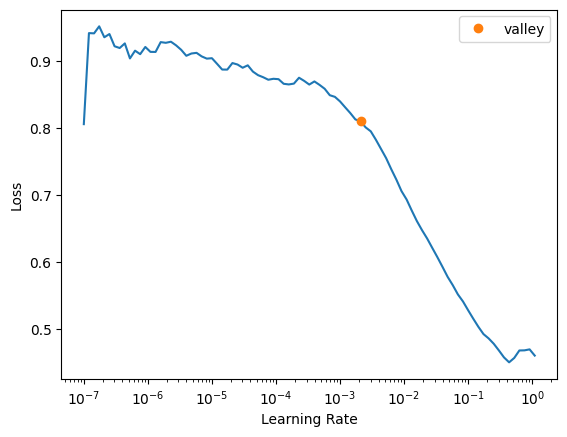

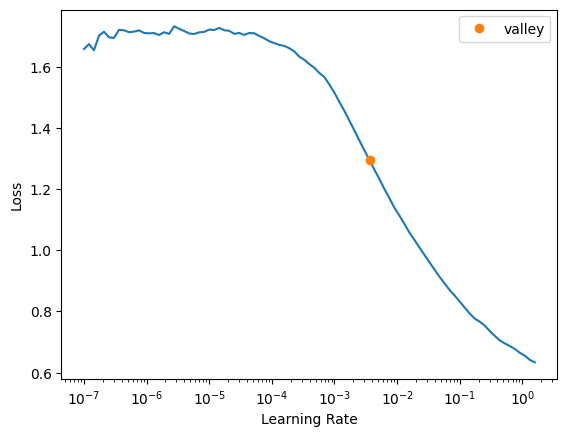

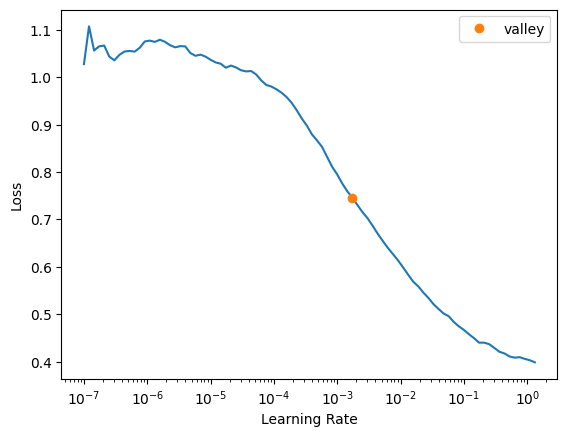

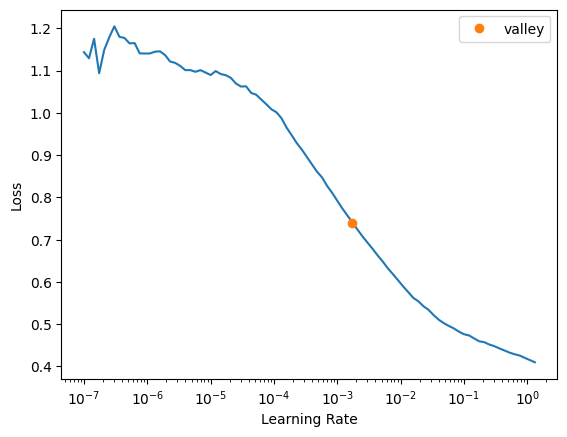

In [22]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


<Figure size 1200x600 with 0 Axes>

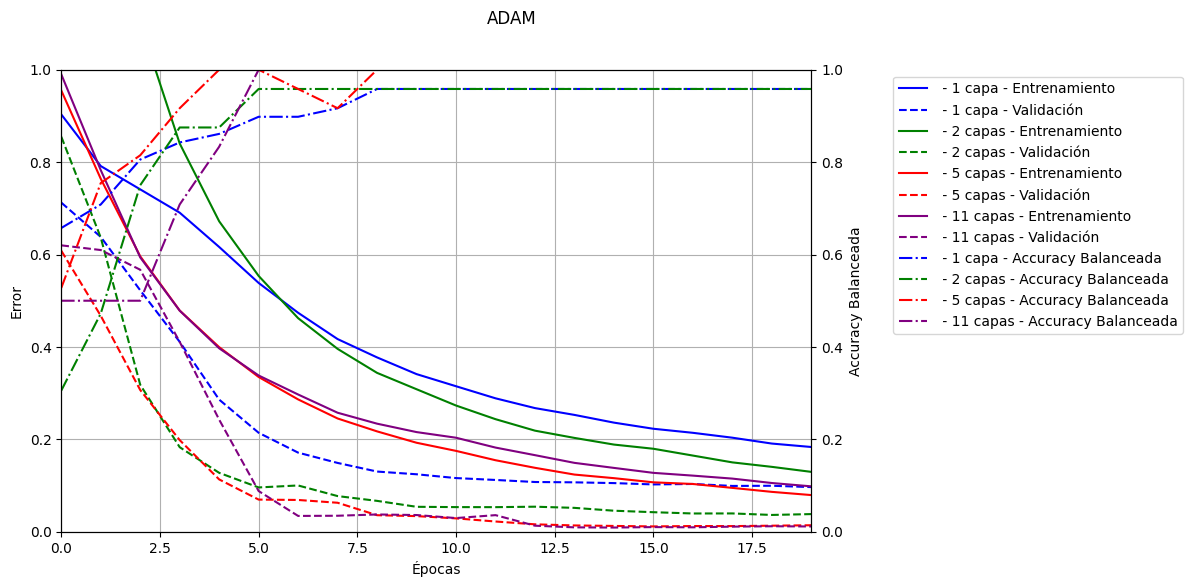

In [19]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='ADAM', names=names_layer, metric=metric)

### AdamW

Better model found at epoch 0 with valid_loss value: 0.7096539735794067.
Better model found at epoch 1 with valid_loss value: 0.6314980387687683.
Better model found at epoch 2 with valid_loss value: 0.5417232513427734.
Better model found at epoch 3 with valid_loss value: 0.39734145998954773.
Better model found at epoch 4 with valid_loss value: 0.2821285128593445.
Better model found at epoch 5 with valid_loss value: 0.2114551067352295.
Better model found at epoch 6 with valid_loss value: 0.17431773245334625.
Better model found at epoch 7 with valid_loss value: 0.1485919952392578.
Better model found at epoch 8 with valid_loss value: 0.13757653534412384.
Better model found at epoch 9 with valid_loss value: 0.1254614293575287.
Better model found at epoch 10 with valid_loss value: 0.11880922317504883.
Better model found at epoch 11 with valid_loss value: 0.11264225095510483.
Better model found at epoch 12 with valid_loss value: 0.11030595749616623.
Better model found at epoch 13 with valid_

Better model found at epoch 0 with valid_loss value: 0.8550119400024414.
Better model found at epoch 1 with valid_loss value: 0.6366994380950928.
Better model found at epoch 2 with valid_loss value: 0.3181403577327728.
Better model found at epoch 3 with valid_loss value: 0.18309898674488068.
Better model found at epoch 4 with valid_loss value: 0.12763245403766632.
Better model found at epoch 5 with valid_loss value: 0.09604308754205704.
Better model found at epoch 7 with valid_loss value: 0.07730833441019058.
Better model found at epoch 8 with valid_loss value: 0.06692223995923996.
Better model found at epoch 9 with valid_loss value: 0.0541161447763443.
Better model found at epoch 10 with valid_loss value: 0.05345289409160614.
Better model found at epoch 11 with valid_loss value: 0.0533469095826149.
Better model found at epoch 13 with valid_loss value: 0.05182930827140808.
Better model found at epoch 14 with valid_loss value: 0.045705463737249374.
Better model found at epoch 15 with va

Better model found at epoch 0 with valid_loss value: 0.6119887232780457.
Better model found at epoch 1 with valid_loss value: 0.4838888645172119.
Better model found at epoch 2 with valid_loss value: 0.32547998428344727.
Better model found at epoch 3 with valid_loss value: 0.21213717758655548.
Better model found at epoch 4 with valid_loss value: 0.12743838131427765.
Better model found at epoch 5 with valid_loss value: 0.07966645061969757.
Better model found at epoch 6 with valid_loss value: 0.07001245021820068.
Better model found at epoch 7 with valid_loss value: 0.06748639047145844.
Better model found at epoch 8 with valid_loss value: 0.047603122889995575.
Better model found at epoch 9 with valid_loss value: 0.040056921541690826.
Better model found at epoch 10 with valid_loss value: 0.033084686845541.
Better model found at epoch 11 with valid_loss value: 0.026572121307253838.
Better model found at epoch 12 with valid_loss value: 0.0220548827201128.
Better model found at epoch 13 with v

Better model found at epoch 0 with valid_loss value: 0.620085597038269.
Better model found at epoch 1 with valid_loss value: 0.611716091632843.
Better model found at epoch 2 with valid_loss value: 0.5806052684783936.
Better model found at epoch 3 with valid_loss value: 0.38895705342292786.
Better model found at epoch 4 with valid_loss value: 0.24470065534114838.
Better model found at epoch 5 with valid_loss value: 0.06783365458250046.
Better model found at epoch 6 with valid_loss value: 0.03703092783689499.
Better model found at epoch 7 with valid_loss value: 0.03487084060907364.
Better model found at epoch 8 with valid_loss value: 0.02805512025952339.
Better model found at epoch 11 with valid_loss value: 0.022642282769083977.
Better model found at epoch 12 with valid_loss value: 0.013255019672214985.
Better model found at epoch 13 with valid_loss value: 0.010097892954945564.
Better model found at epoch 14 with valid_loss value: 0.009648352861404419.
Better model found at epoch 15 with

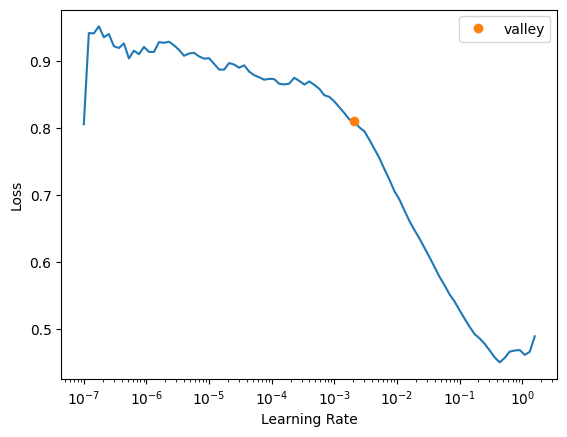

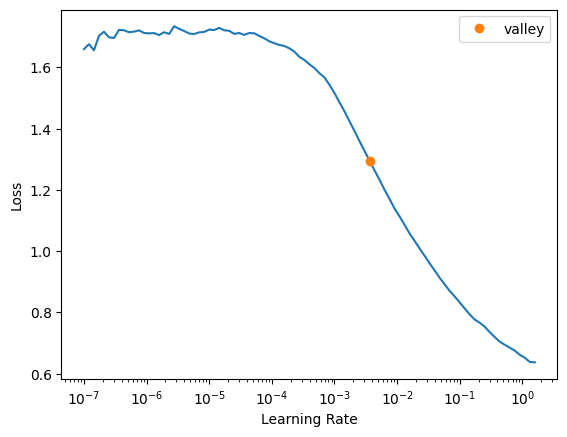

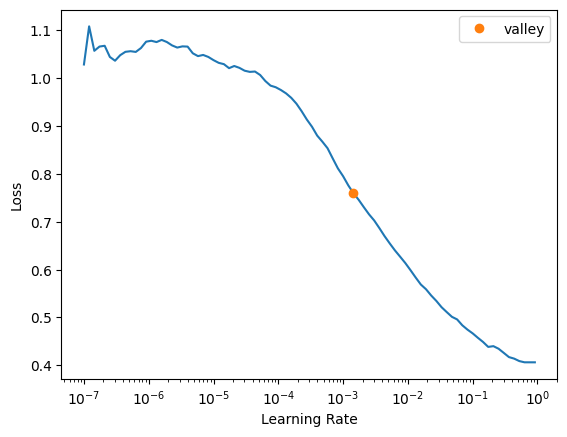

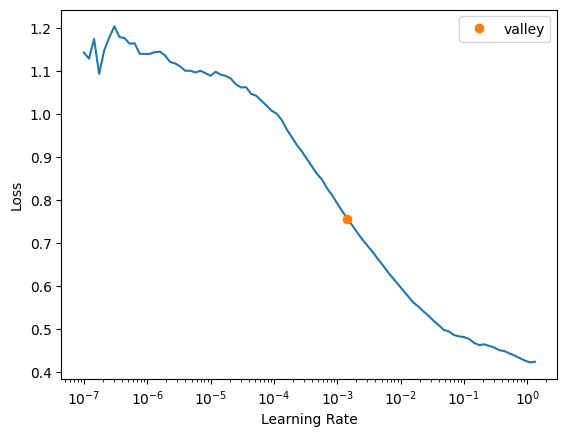

In [24]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAMW'].items():
  utilsTFG.set_seed()
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAMW'][layer] = end-start

<Figure size 1200x600 with 0 Axes>

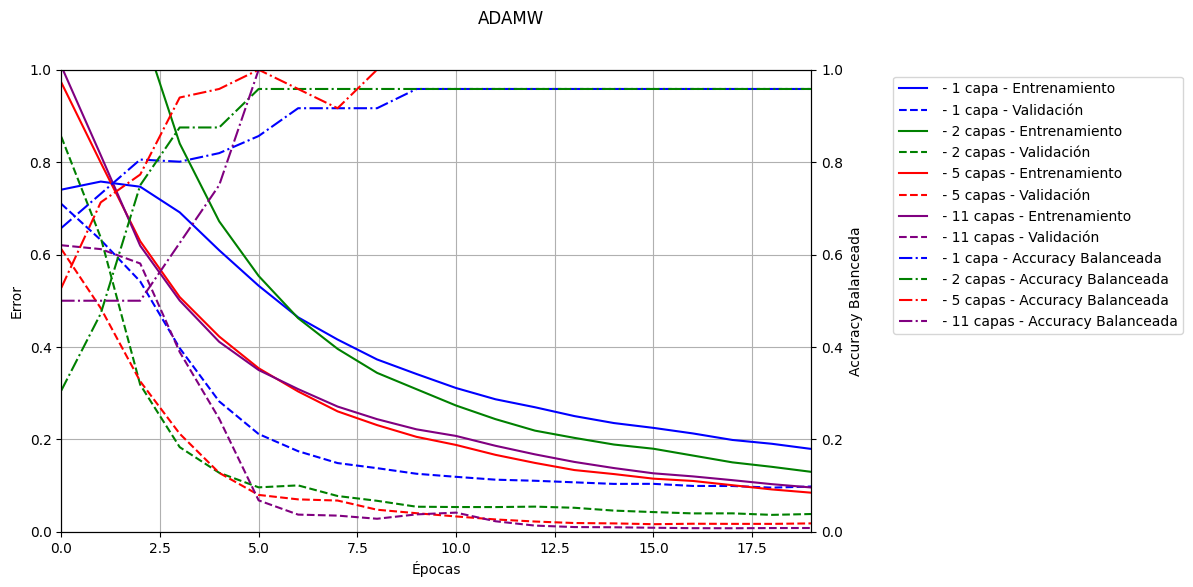

In [17]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAMW'].values(), title='ADAMW', names=names_layer, metric=metric)

### Save or Load models

In [26]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)

file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_gd, f)

In [16]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/notebooks/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']

file_path = f'/notebooks/saved_models/learner_times_{dataset}.pkl'
with open(file_path, 'rb') as f:
    time_gd = pickle.load(f)

### Comparative per layers

<Figure size 1200x600 with 0 Axes>

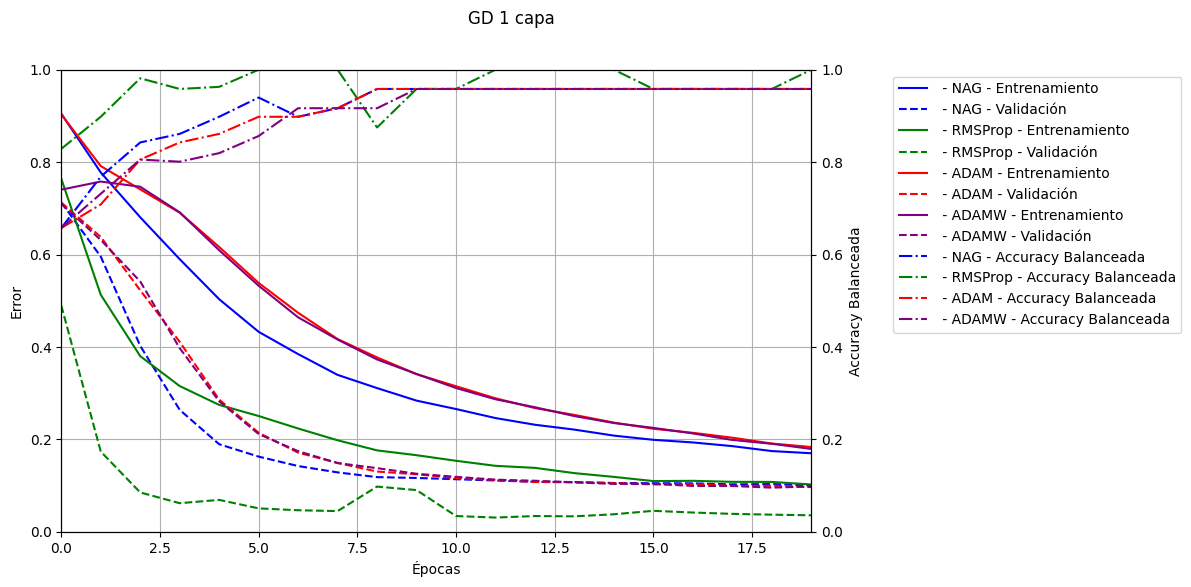

<Figure size 1200x600 with 0 Axes>

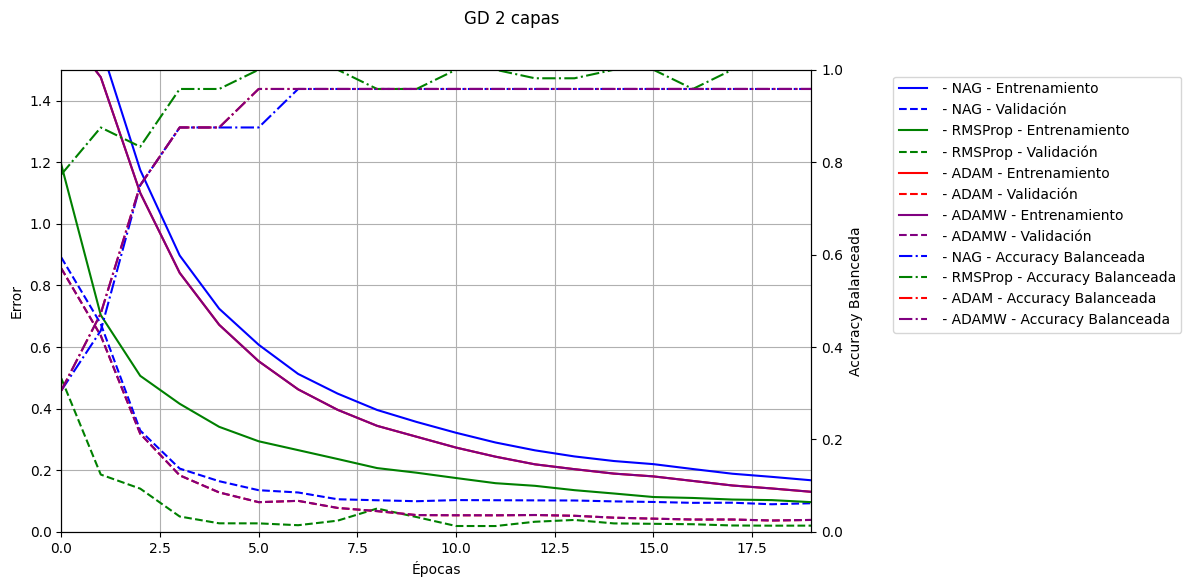

<Figure size 1200x600 with 0 Axes>

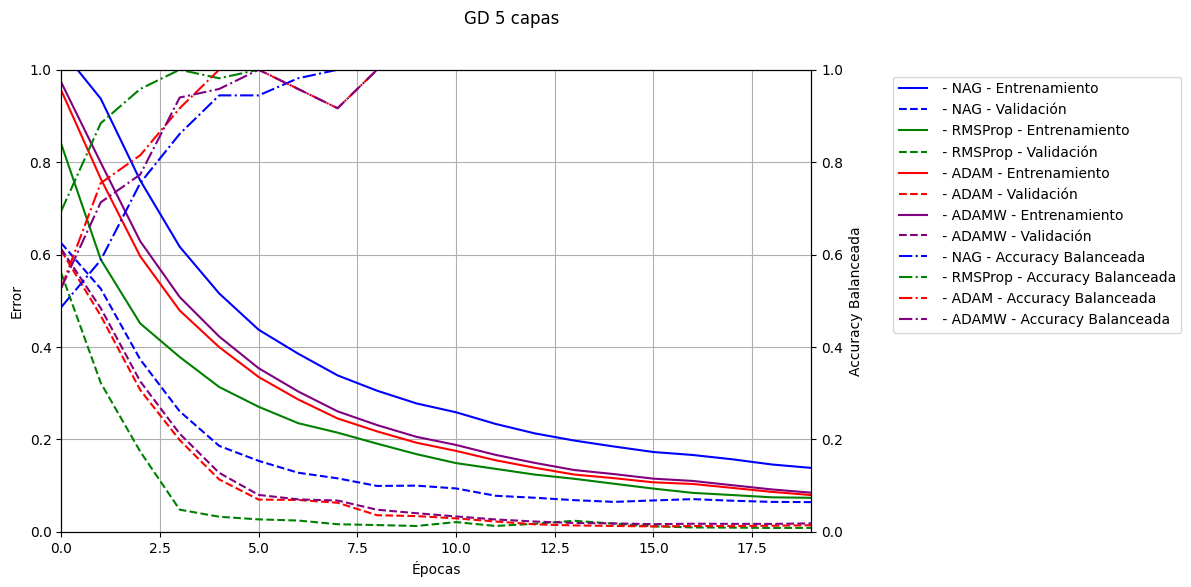

<Figure size 1200x600 with 0 Axes>

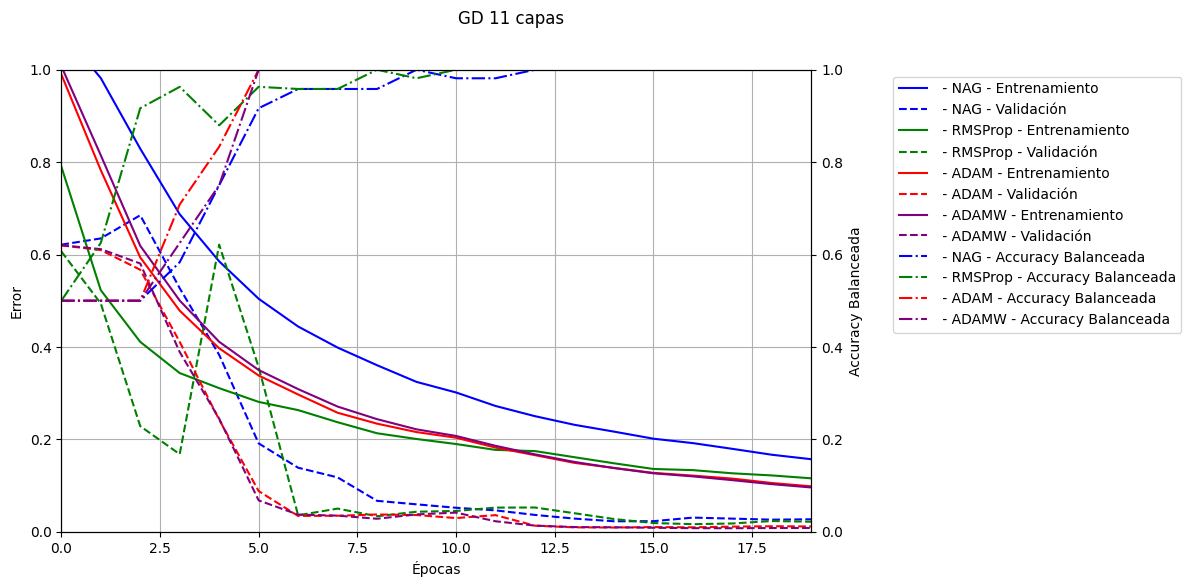

In [22]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1], learners['ADAMW'][1] ]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2], learners['ADAMW'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5], learners['ADAMW'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11], learners['ADAMW'][11]]

names=['NAG', 'RMSProp', 'ADAM', 'ADAMW']
utilsTFG.plot_learners_training(learners_1_layer, title='GD 1 capa', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, title='GD 2 capas', lim=1.5, names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, title='GD 5 capas', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, title='GD 11 capas', names=names, metric=metric)

### Generalization

In [23]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Balanced Accuracy: {accuracy}")

Optimizer: NAG, Layers: 1, Loss: 0.11057180166244507, Balanced Accuracy: 0.9509090909090909


Optimizer: NAG, Layers: 2, Loss: 0.0803522914648056, Balanced Accuracy: 0.97


Optimizer: NAG, Layers: 5, Loss: 0.06675443053245544, Balanced Accuracy: 1.0


Optimizer: NAG, Layers: 11, Loss: 0.0855526328086853, Balanced Accuracy: 0.96


Optimizer: RMSProp, Layers: 1, Loss: 0.05968618765473366, Balanced Accuracy: 0.9709090909090909


Optimizer: RMSProp, Layers: 2, Loss: 0.030774280428886414, Balanced Accuracy: 0.99


Optimizer: RMSProp, Layers: 5, Loss: 0.01874769851565361, Balanced Accuracy: 1.0


Optimizer: RMSProp, Layers: 11, Loss: 0.047298040241003036, Balanced Accuracy: 0.980909090909091


Optimizer: ADAM, Layers: 1, Loss: 0.10947714745998383, Balanced Accuracy: 0.96


Optimizer: ADAM, Layers: 2, Loss: 0.041481636464595795, Balanced Accuracy: 0.98


Optimizer: ADAM, Layers: 5, Loss: 0.023840151727199554, Balanced Accuracy: 1.0


Optimizer: ADAM, Layers: 11, Loss: 0.06321070343255997, Balanced Accuracy: 0.9509090909090909


Optimizer: ADAMW, Layers: 1, Loss: 0.1080249547958374, Balanced Accuracy: 0.96


Optimizer: ADAMW, Layers: 2, Loss: 0.041781485080718994, Balanced Accuracy: 0.98


Optimizer: ADAMW, Layers: 5, Loss: 0.026061903685331345, Balanced Accuracy: 1.0


Optimizer: ADAMW, Layers: 11, Loss: 0.09421958774328232, Balanced Accuracy: 0.9709090909090909


## Metaheuristics

In [15]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}
utilsTFG.set_seed()

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  optim=RMSProp
  mh_learners[n_layer] = tabular_learner(dls, n_out=2, layers=layer, opt_func=optim, cbs=[SaveModelCallback()], metrics=utilsTFG.balanced_accuracy_func, loss_func=CrossEntropyLossFlat())
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    #population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    #fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=5


In [ ]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(population, f)
    
file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(fitness, f)

In [ ]:
file_path = f'/notebooks/saved_models/{dataset}_population.pkl'
with open(file_path, 'rb') as f:
    population = pickle.load(f)
    
file_path = f'/notebooks/saved_models/{dataset}_fitness.pkl'
with open(file_path, 'rb') as f:
    fitness = pickle.load(f)

In [16]:
for alg in algs:
    file_path = f'/notebooks/saved_models/{alg}_dict_{dataset}.pkl'
    with open(file_path, 'rb') as f:
        results[alg] = pickle.load(f)
    file_path = f'/notebooks/saved_models/{alg}_time_{dataset}.pkl'
    with open(file_path, 'rb') as f:
        time_mh[alg] = pickle.load(f)

### Genetic Algorithms

In [ ]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [ ]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE'], f)
    
file_path = f'/notebooks/saved_models/SHADE_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE'], f)


In [17]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  fitness_valid['SHADE'][layer] = []
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [18]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [0.5452744364738464, 0.4741743206977844, 0.37899646162986755, 0.3110438585281372, 0.25332900881767273, 0.22762103378772736, 0.22286450862884521, 0.21952727437019348, 0.21952727437019348, 0.21335728466510773, 0.17625616490840912, 0.16365230083465576, 0.16365230083465576, 0.16365230083465576, 0.16365230083465576, 0.16365230083465576, 0.16365230083465576, 0.14492158591747284, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11847909539937973, 0.11201205104589462, 0.11201205104589462, 0.11201205104589462, 0.11201205104589462, 0.11201205104589462, 0.10725656896829605, 0.10725656896829605, 0.10725656896829605, 0.10725656896829605, 0.10725656896829605, 0.10725656896829605, 0.10725656896829605, 0.10725656896829605

In [19]:
#Modify the shade lenght to adjust the others algorithms. I have selected the best before so we cant lose it.
for layer in n_layers:
    # Convert the tuple to a list
    shade_list = list(results['SHADE'][layer])
    
    # Modify the list
    shade_list[6] = [np.mean(shade_list[6][i:i+5]) for i in range(0, len(shade_list[6]), 5)]
    
    # Convert the list back to a tuple and assign it back to results['SHADE'][layer]
    results['SHADE'][layer] = tuple(shade_list)
    
    
    
    fitness_valid['SHADE'][layer] = [np.mean(fitness_valid['SHADE'][layer][i:i+5]) for i in range(0, len(fitness_valid['SHADE'][layer]), 5)]

### SHADE-ILS

In [ ]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-ILS_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS'], f)
    
file_path = f'/notebooks/saved_models/SHADE-ILS_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS'], f)


In [20]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [21]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [0.5452744364738464, 0.10108418762683868, 0.09506458044052124, 0.07558589428663254, 0.07558589428663254, 0.07558589428663254, 0.07558589428663254, 0.07558589428663254, 0.07558589428663254, 0.07558589428663254, 0.07558589428663254, 0.07467792183160782, 0.07466228306293488, 0.07466228306293488, 0.07466228306293488, 0.07417312264442444, 0.07417312264442444, 0.07417312264442444, 0.07417312264442444, 0.07417312264442444, 0.07309642434120178]
Validation error of SHADE-ILS for 1 layers: [0.576790988445282, 0.24536871910095215, 0.19209668040275574, 0.18240424990653992, 0.18240424990653992, 0.18240424990653992, 0.18240424990653992, 0.18240424990653992, 0.18240424990653992, 0.18240424990653992, 0.18240424990653992, 0.16880138218402863, 0.17296841740608215, 0.17296841740608215, 0.17296841740608215, 0.17855672538280487, 0.17855672538280487, 0.17855672538280487, 0.17855672538280487, 0.17855672538280487, 0.1582440286874771]
Difference: [0.03151655 0.14428453

### SHADE-GD

In [ ]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-GD'], f)
    
file_path = f'/notebooks/saved_models/SHADE-GD_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-GD'], f)


In [22]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [23]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [0.5452744364738464, 0.22762103378772736, 0.18919169902801514, 0.15429142117500305, 0.15429142117500305, 0.13997389376163483, 0.13997389376163483, 0.10752220451831818, 0.08358900994062424, 0.08358900994062424, 0.08358900994062424, 0.08210842311382294, 0.08210842311382294, 0.08107669651508331, 0.08107669651508331, 0.08107669651508331, 0.08107669651508331, 0.08107669651508331, 0.08107669651508331, 0.08107669651508331, 0.08107669651508331, 0.06636052578687668]
Validation error of SHADE-GD for 1 layers: [0.576790988445282, 0.3816734552383423, 0.4311639368534088, 0.1771548092365265, 0.1771548092365265, 0.263519823551178, 0.263519823551178, 0.17675724625587463, 0.19711461663246155, 0.19711461663246155, 0.19711461663246155, 0.18016347289085388, 0.18016347289085388, 0.28546926379203796, 0.28546926379203796, 0.28546926379203796, 0.28546926379203796, 0.28546926379203796, 0.28546926379203796, 0.28546926379203796, 0.28546926379203796, 0.23018325865268707]
D

### SHADE-ILS-GD

In [ ]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  utilsTFG.set_seed()
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start

file_path = f'/notebooks/saved_models/SHADE-ILS-GD_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results['SHADE-ILS-GD'], f)
    
file_path = f'/notebooks/saved_models/SHADE-ILS-GD_time_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(time_mh['SHADE-ILS-GD'], f)


In [24]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [25]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [0.5452744364738464, 0.10108418762683868, 0.08536820113658905, 0.07711806148290634, 0.06895541399717331, 0.06453478336334229, 0.06453478336334229, 0.06160397455096245, 0.06160397455096245, 0.06160397455096245, 0.06160397455096245, 0.061543822288513184, 0.061543822288513184, 0.061543822288513184, 0.061543822288513184, 0.061543822288513184, 0.06056340038776398, 0.06056340038776398, 0.05716163292527199, 0.05716163292527199, 0.05716163292527199]
Validation error of SHADE-ILS-GD for 1 layers: [0.576790988445282, 0.24536871910095215, 0.20513103902339935, 0.18802040815353394, 0.17703038454055786, 0.16727420687675476, 0.16727420687675476, 0.15427295863628387, 0.15427295863628387, 0.15427295863628387, 0.15427295863628387, 0.15658311545848846, 0.15658311545848846, 0.15658311545848846, 0.15658311545848846, 0.15658311545848846, 0.16341087222099304, 0.16341087222099304, 0.16313697397708893, 0.16313697397708893, 0.16313697397708893]
Difference: [0.0315165

### Comparison between MH

In [26]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [27]:
#Calculate accuracy and balanced accuracy
bal_acc = {}
for mh in algs:
  bal_acc[mh] = {}
  for layer in n_layers:
    bal_acc[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      bal_acc[mh][layer].append(utilsTFG.balanced_accuracy_func(preds, targs))

<Figure size 1200x600 with 0 Axes>

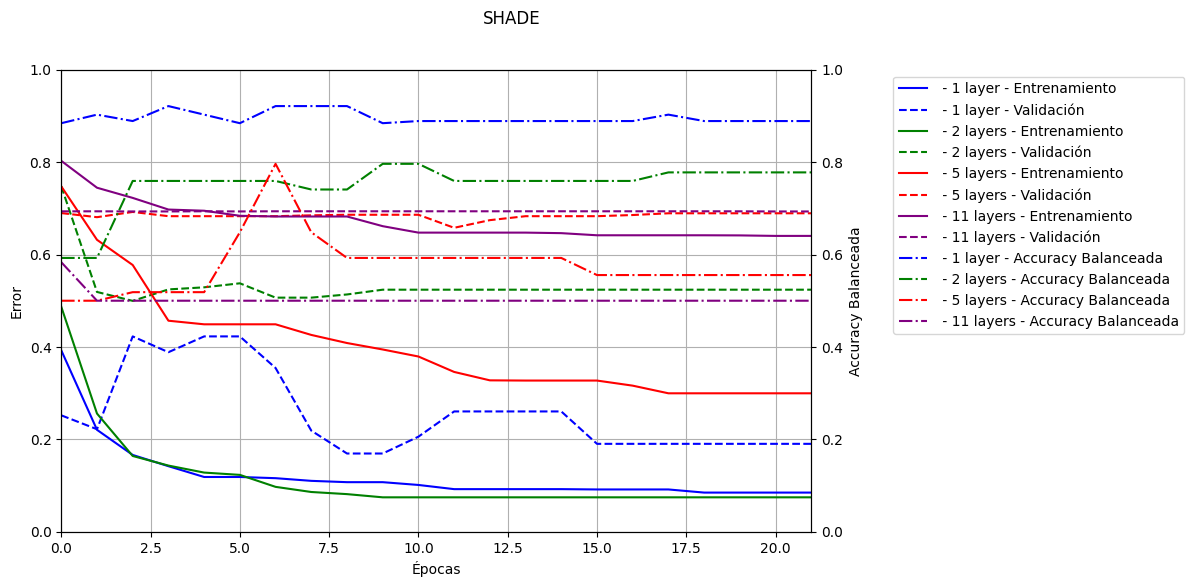

<Figure size 1200x600 with 0 Axes>

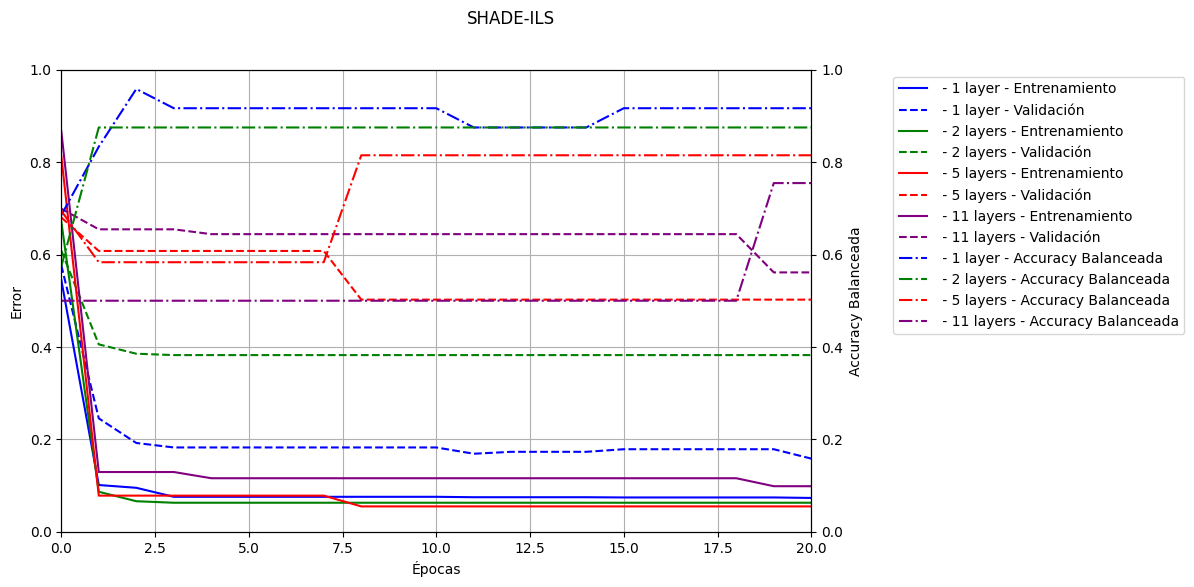

<Figure size 1200x600 with 0 Axes>

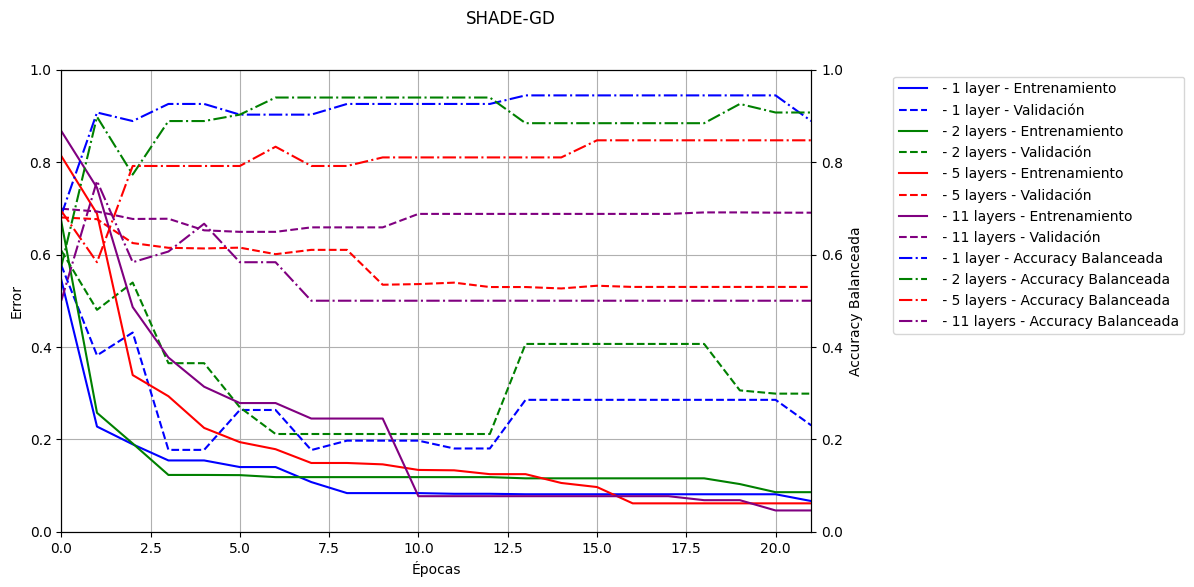

<Figure size 1200x600 with 0 Axes>

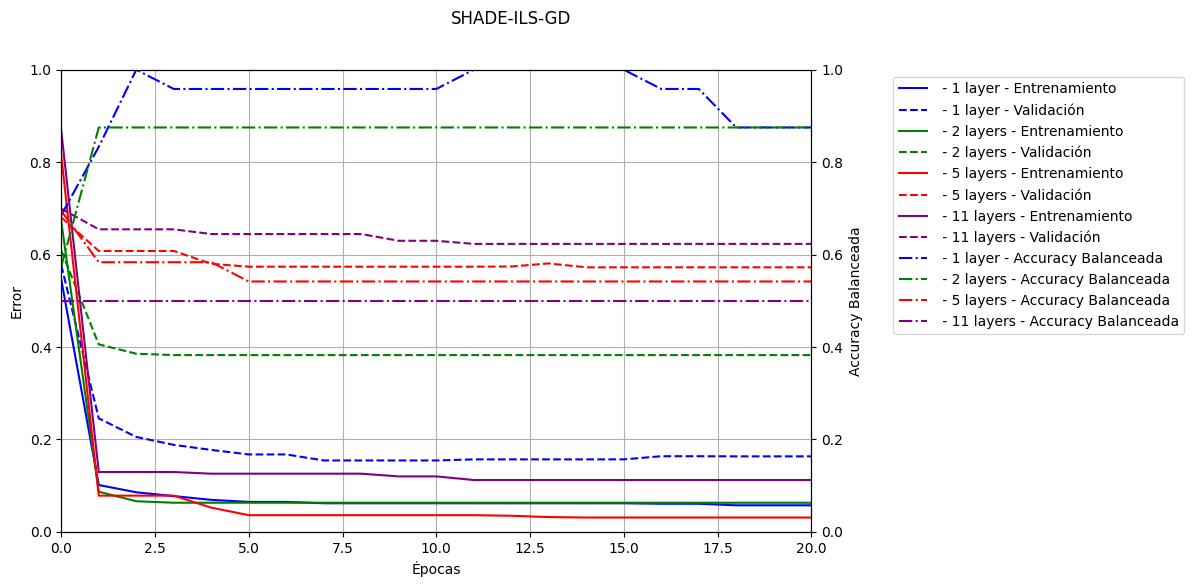

In [28]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], bal_acc[alg],  layers = n_layers, names=names, title=f'{alg}', metric='BalAcc')

<Figure size 1200x600 with 0 Axes>

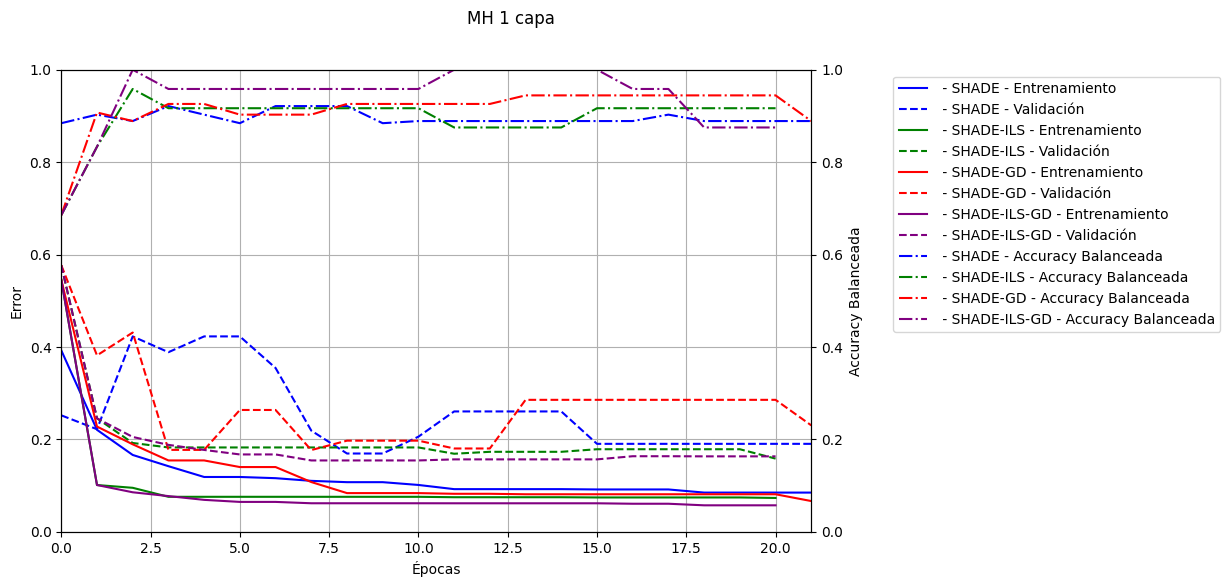

<Figure size 1200x600 with 0 Axes>

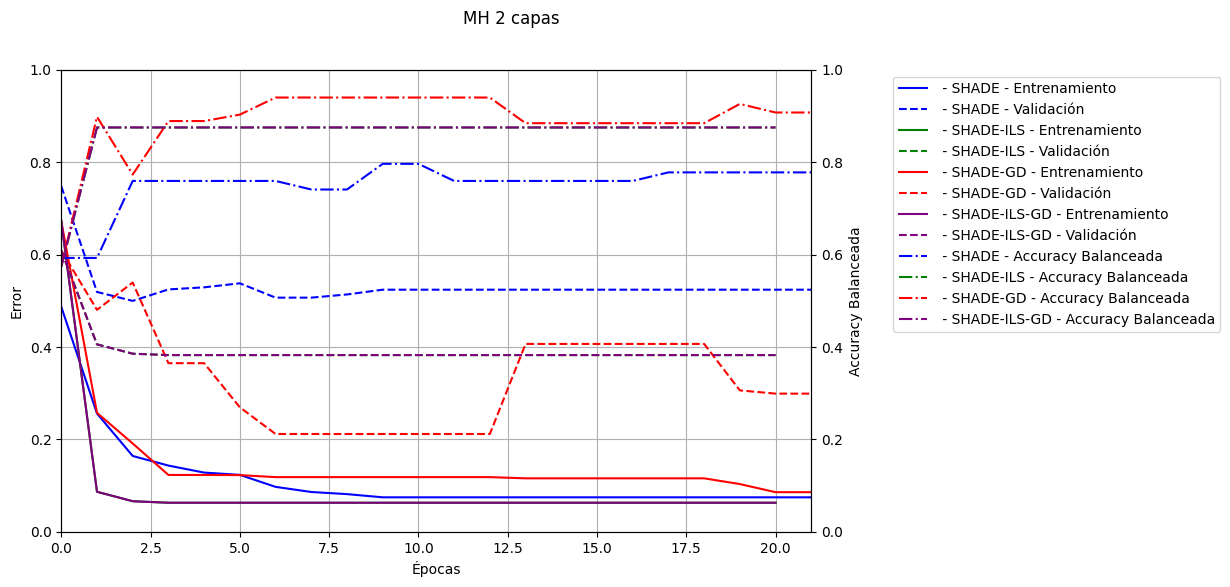

<Figure size 1200x600 with 0 Axes>

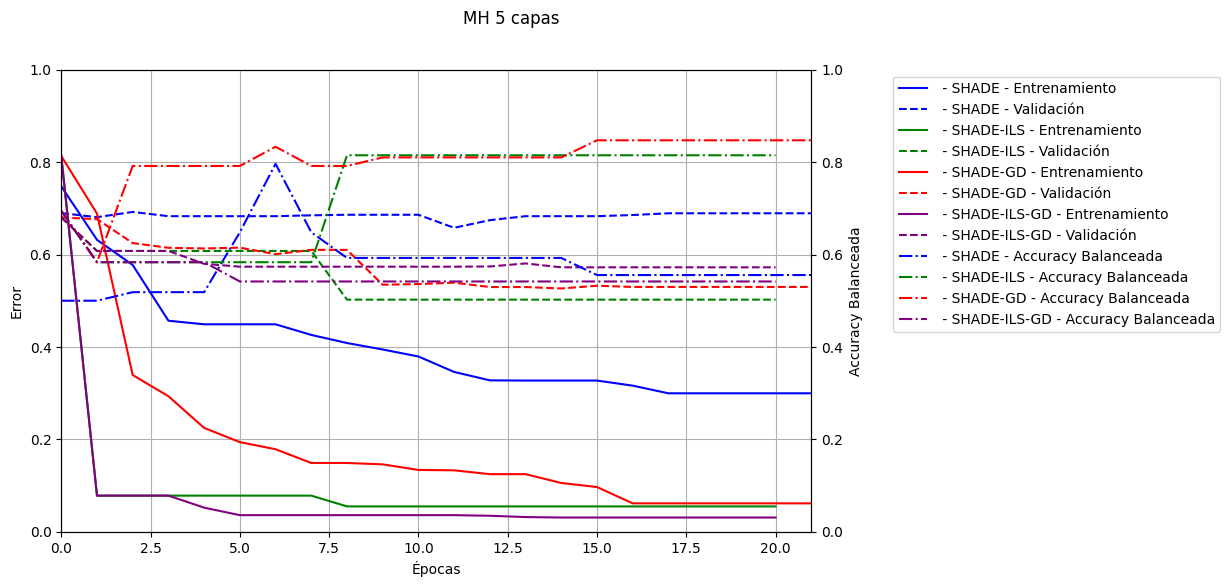

<Figure size 1200x600 with 0 Axes>

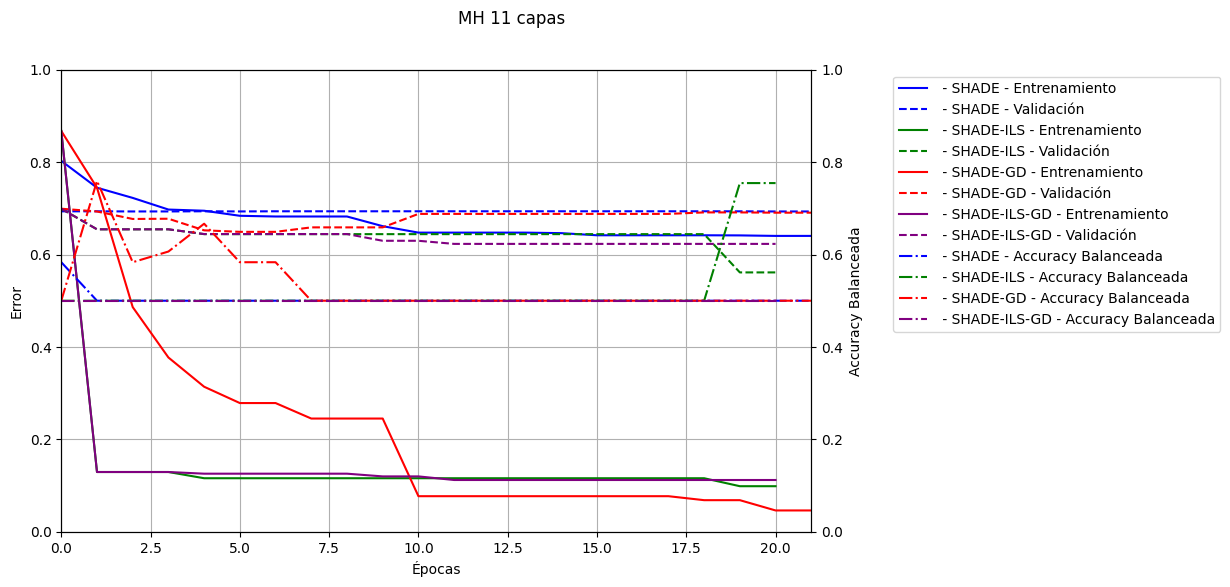

In [31]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
acc = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  acc[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    acc[layer][alg] = bal_acc[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  c = 'capa' if layer==1 else 'capas'
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], acc[layer], layers = names, names=names, title=f'MH {layer} {c}', metric='BalAcc')

### Generalization

In [75]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate F1-Score
    #f1 = utilsTFG.f1_score_func(preds, targs)

    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, Balanced accuracy: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 0.18655292689800262, Balanced accuracy: 0.9309090909090909


Optimizer: SHADE, Layers: 2, Loss: 0.49325865507125854, Balanced accuracy: 0.7254545454545455


Optimizer: SHADE, Layers: 5, Loss: 0.6462705135345459, Balanced accuracy: 0.8254545454545454


Optimizer: SHADE, Layers: 11, Loss: 0.6930629014968872, Balanced accuracy: 0.5


Optimizer: SHADE-ILS, Layers: 1, Loss: 0.14217527210712433, Balanced accuracy: 0.97


Optimizer: SHADE-ILS, Layers: 2, Loss: 0.3501390516757965, Balanced accuracy: 0.9318181818181819


Optimizer: SHADE-ILS, Layers: 5, Loss: 0.4754406809806824, Balanced accuracy: 0.8909090909090909


Optimizer: SHADE-ILS, Layers: 11, Loss: 0.4909142851829529, Balanced accuracy: 0.9027272727272727


Optimizer: SHADE-GD, Layers: 1, Loss: 0.1811356097459793, Balanced accuracy: 0.9154545454545454


Optimizer: SHADE-GD, Layers: 2, Loss: 0.22257372736930847, Balanced accuracy: 0.9527272727272726


Optimizer: SHADE-GD, Layers: 5, Loss: 0.4519875645637512, Balanced accuracy: 0.8790909090909091


Optimizer: SHADE-GD, Layers: 11, Loss: 0.659540593624115, Balanced accuracy: 0.6


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 0.15944258868694305, Balanced accuracy: 0.9409090909090909


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 0.3501390516757965, Balanced accuracy: 0.9318181818181819


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 0.6156840324401855, Balanced accuracy: 0.6


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 0.7037687301635742, Balanced accuracy: 0.5


## Time comparison

In [18]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by SHADE training with 1 layers: 126.8288 seconds
Time consumed by SHADE training with 2 layers: 135.3098 seconds
Time consumed by SHADE training with 5 layers: 214.6953 seconds
Time consumed by SHADE training with 11 layers: 1265.4345 seconds
Time consumed by SHADE-ILS training with 1 layers: 135.7381 seconds
Time consumed by SHADE-ILS training with 2 layers: 147.1800 seconds
Time consumed by SHADE-ILS training with 5 layers: 251.2176 seconds
Time consumed by SHADE-ILS training with 11 layers: 1789.5938 seconds
Time consumed by SHADE-GD training with 1 layers: 200.2840 seconds
Time consumed by SHADE-GD training with 2 layers: 220.7514 seconds
Time consumed by SHADE-GD training with 5 layers: 315.5297 seconds
Time consumed by SHADE-GD training with 11 layers: 1779.6579 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 210.2648 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 224.8982 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 36

In [29]:
#GD
for alg, time_layers in time_full_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.03f} seconds')

Time consumed by SHADE training with 1 layers: 130.462 seconds
Time consumed by SHADE training with 2 layers: 139.024 seconds
Time consumed by SHADE training with 5 layers: 218.411 seconds
Time consumed by SHADE training with 11 layers: 1273.243 seconds
Time consumed by SHADE-ILS training with 1 layers: 136.436 seconds
Time consumed by SHADE-ILS training with 2 layers: 147.795 seconds
Time consumed by SHADE-ILS training with 5 layers: 251.935 seconds
Time consumed by SHADE-ILS training with 11 layers: 1791.067 seconds
Time consumed by SHADE-GD training with 1 layers: 200.284 seconds
Time consumed by SHADE-GD training with 2 layers: 220.751 seconds
Time consumed by SHADE-GD training with 5 layers: 315.530 seconds
Time consumed by SHADE-GD training with 11 layers: 1779.658 seconds
Time consumed by SHADE-ILS-GD training with 1 layers: 210.265 seconds
Time consumed by SHADE-ILS-GD training with 2 layers: 224.898 seconds
Time consumed by SHADE-ILS-GD training with 5 layers: 368.588 seconds
